# 1. scipy.optimize

## Content
- [1.2 Nonlinear programming](#1.2-Nonlinear-programming)
  - [Example 1: Linear constraints](#Example-1:-Cobb-Douglas-Production-Technology-(Nonlinear-Objective-with-Linear-Constraint))
    - [Analytical solution](#Analytical-solution-(Ex1))
    - [Unconstrained univariate](#(1)-Unconstrained-univariate-minimization:-minimize_scalar)
    - [Local (multivariate) minimization](#(2)-Local-(multivariate)-minimization:-minimize)
      - [Bounded univariate minimization](#Bounded-univariate-minimization:-A-comparison)
      - [Constrained multivariate minimization](#Constrained-multivariate-minimization)
    - [Global minimization](#(3)-Global-minimization)
      - [basinhopping](#basinhopping)
      - [brute](#brute)
      - [differential_evolution](#differential_evolution)
      - [shgo](#shgo-(simplicial-homology-global-optimization))
      - [dual_annealing](#dual_annealing)
    - [The family of fmin](#(4)-The-famlily-of-fmin)
      - [General-purpose multivariate methods](#General-purpose-multivariate-methods)
      - [Constrained multivariate methods](#Constrained-multivariate-methods)
      - [Univariate minimization methods](#Univariate-(scalar)-minimization-methods)
    - [Plot](#(5)-Plot)
  - [Example 2: Nonlinear constraints](#Example-2:-Aurtaky-Economy-(Nonlinear-Objective-with-Nonlinear-Constraint))
    - [Analytical solution](#Analytical-solution-(Ex2))
    - [Numerical solution](#Numerical-solution-(Ex2))
    - [Plot](#Plot-(Ex2))
  - [Example 3: Nonlinear constraints in 3D](#Example-3:-Cubic-Extension-to-Example-2)
    - [Analytical solution](#Analytical-solution-(Ex3))
    - [Numerical solution](#Numerical-solution-(Ex3))
    - [Plot](#Plot-(Ex3))
  - [Example 4: Satiation point](#Example-4:-Satiation-Point)
  - [Example 5: Linear programming](#Example-5:-Linear-Programming)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from warnings import filterwarnings

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import *

import sympy as sp

We write a function to print some key results of various methods in this package!

In [2]:
def try_minimize(func, methods, guess=[], min_flag=-1, command='minimize', variate=0, args=(), bounds=None, constraints=None, **kwds):
    '''
    Minimization of scalar function of one or more variables.
    See the docstring of `scipy.optimize`.
    Modified from: http://luly.lamost.org/blog/scipy_minimize.html
    
    min_flag: -1 if max originally else 1
    variate: 0 if univariate and 1 else
    
    '''
    from scipy.optimize import minimize,basinhopping, shgo, dual_annealing
    import numpy as np
    import time

    methods = methods
    results = []
    
    for method in methods:
        try:
            if command == 'minimize':
                if variate == 0: # univariate
                    command += '(func, guess, args=args, method=method, **kwds)'
                elif variate == 1: # multivariate
                    command += '(func, guess, args=args, method=method, bounds=bounds, constraints=constraints, **kwds)'
                success = 'res.success'    
                
            elif command == 'basinhopping':              
                if variate == 0:
                    command += '(func, guess, minimizer_kwargs={"method": method,"tol":1e-6}, **kwds)'
                elif variate == 1: 
                    command += '(func, guess, minimizer_kwargs={"method": method,"tol":1e-6,\
                    "bounds":bounds,"constraints":constraints}, **kwds)'       
                success = 'res.lowest_optimization_result.success'
                
            elif command == 'shgo':
                command += '(func, bounds, minimizer_kwargs={"method": method,"tol":1e-6}, **kwds)'
                success = 'res.success'    
                
            elif command == 'dual_annealing': 
                command += '(func, bounds, local_search_options={"method": method,"tol":1e-6}, **kwds)'
                success = 'res.success'    
                            
            time_start = time.time()
            res = eval(command)
            time_end =time.time()
            if method == 'COBYLA':
                res.nit = 'None'
            res.method = method
            res.time = time_end - time_start
            results.append(res)
            
        except ValueError as err:
            print("{:>12s}: {}".format(method, err))
            continue         
            
    print("\n---------------------------------------------------------------------------------\n")
    
    results.sort(key=lambda res: res.fun)
    
    import prettytable as pt
    tb = pt.PrettyTable()
    tb.field_names = ['method', 'success','function','solution','time','# iterations']
    
    for res in results:
        res.fun = np.array(res.fun).reshape(1,)[0]
        out = [res.method, str(eval(success)), min_flag*res.fun, \
              np.array2string(res.x, formatter=dict(all=lambda x: "%10g" % x), separator=','), '%.6f'%res.time, res.nit]
        tb.add_row(out)
    
    print(tb)
    
    return results[0]

We also find two functions to draw the 3D plot and the contour plot of the problems!

In [3]:
def draw3D(Z1,Z2):
    '''
    Modified from: https://blog.csdn.net/qq_33757398/article/details/82834888
    
    '''
    fig = plt.figure()
    ax = Axes3D(fig)
    x_arange = np.linspace(0, 25, 100)
    y_arange = np.linspace(0, 25, 100)
    X, Y = np.meshgrid(x_arange, y_arange)
    Z1 = eval(Z1)
    Z2 = eval(Z2)
    plt.xlabel('x')
    plt.ylabel('y')
    ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='rainbow')
    ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap='rainbow')
    plt.show()

In [4]:
def drawContour(Z1,Z2):
    '''
    Modified from: https://blog.csdn.net/qq_33757398/article/details/82834888
    
    '''
    x_arange = np.linspace(0, 25, 100)
    y_arange = np.linspace(0, 25, 100)
    X, Y = np.meshgrid(x_arange, y_arange)
    Z1 = eval(Z1)
    Z2 = eval(Z2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.contourf(X, Y, Z1, 8, alpha=0.75, cmap='rainbow')
    plt.contourf(X, Y, Z2, 8, alpha=0.75, cmap='rainbow')
    C1 = plt.contour(X, Y, Z1, 8, colors='black')
    C2 = plt.contour(X, Y, Z2, 8, colors='blue')
    plt.clabel(C1, inline=1, fontsize=10)
    plt.clabel(C2, inline=1, fontsize=10)
    plt.show()

## 1.2 Nonlinear programming

### Example 1: Cobb-Douglas Production Technology (Nonlinear Objective with Linear Constraint)

$$
\begin{aligned}
\max_{K,L} \quad & K^\frac{1}{3}L^\frac{2}{3}\\
\text{s.t.} \quad & 4K + 5L \leq 100
\end{aligned}
$$

Of course we can solve either by Lagrangian or by substituting out one of the two choice variables to convert to problem into an unconstrained one. Here we focus on what scipy.optimize can do for us.

### Analytical solution (Ex1)

In [5]:
k = sp.symbols('k')
obj_sym = k ** (1/3) * ((100-4*k)/5) ** (2/3)
fprime_sym = obj_sym.diff(k)
fprime_sym

0.333333333333333*k**(-0.666666666666667)*(20 - 4*k/5)**0.666666666666667 - 0.533333333333333*k**0.333333333333333*(20 - 4*k/5)**(-0.333333333333333)

Analytical solution:

In [6]:
k_sol = sp.solve(fprime_sym)
k_sol

[8.33333333333333]

### (1) Unconstrained univariate minimization: minimize_scalar

The problem can be converted to:

$$\max_{K} \quad K^{0.33}\bigg(\frac{100-4K}{5}\bigg)^{0.67}$$

In [7]:
def obj1(x,α= 1/3,β= 2/3):
    return -x ** α * ((100 - 4*x)/5) ** β

In [8]:
filterwarnings("ignore")
res_bound = minimize_scalar(obj1, bounds=(0,25), method='bounded',tol=1e-6)
print(res_bound)
# status 0 means success

     fun: -11.399839644511312
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 8.333333301419751


In [9]:
%timeit minimize_scalar(obj1, bounds=(0,25), method='bounded',tol=1e-6)

300 µs ± 8.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Using brent method by default.

In [10]:
res_brent = minimize_scalar(obj1, bounds=(0,25), method='brent',tol=1e-6)
res_brent

     fun: -11.399839644511212
    nfev: 18
     nit: 8
 success: True
       x: 8.333331774438696

In [11]:
%timeit minimize_scalar(obj1, bounds=(0,25), method='brent',tol=1e-6)

132 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
res_golden = minimize_scalar(obj1, bounds=(0,25), method='golden',tol=1e-6)
res_golden

     fun: -11.399839644511307
    nfev: 38
     nit: 27
 success: True
       x: 8.333332924232964

In [13]:
%timeit minimize_scalar(obj1, bounds=(0,25), method='golden',tol=1e-6)

102 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### (2) Local (multivariate) minimization: minimize

In [14]:
def obj2(x,α= 1/3,β= 2/3):
    return -x[0] ** α * x[1] ** β

In [15]:
cons = ({'type': 'ineq', 'fun': lambda x: 100 - 4*x[0] - 5*x[1]}) # 'ineq' means non-negativity
cons_eq = ({'type': 'eq', 'fun': lambda x: 100 - 4*x[0] - 5*x[1]}) 
bnds1 = ((0, None), (0, None))
bnds2 = ((0, 25), (0, 20))
x0 = [10,10]

There are 14 methods in total: Nelder-Mead, Powell, CG, BFGS, Newton-CG, L-BFGS-B, TNC, COBYLA, SLSQP, trust-constr, dogleg, trust-ncg, trust-krylov, trust-exact. Some return status 0 for success while others denote by 1.

#### Bounded univariate minimization: A comparison

In [16]:
methods1 = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 
               'trust-constr', 'dogleg', 'trust-ncg','trust-krylov','trust-exact']
res_1 = try_minimize(obj1, methods1, guess=[8], tol=1e-6)

   Newton-CG: Jacobian is required for Newton-CG method
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+--------------+---------+--------------------+--------------+----------+--------------+
|    method    | success |      function      |   solution   |   time   | # iterations |
+--------------+---------+--------------------+--------------+----------+--------------+
|    Powell    |   True  | 11.399839644511314 | [   8.33333] | 0.003989 |      2       |
| trust-constr |   True  | 11.39983964451131  | [   8.33333] | 0.014959 |      5       |
| Nelder-Mead  |   True  | 11.399839644511308 | [   8.33333] | 0.001992 |      20      |
|     BFGS     |   True  | 11.3998396445

<br>======================================================================================================

**Newton-CG, dogleg, trust-ncg, trust-exact, trust-krylov algorithms all require Jacobian**

======================================================================================================

#### Constrained multivariate minimization

Powell, L-BFGS-B, TNC are only bound methods.<br>
COBYLA, SLSQP, trust-constr can handle constrained problem

#### comparison

In [17]:
filterwarnings("ignore")
methods2 = ['COBYLA', 'SLSQP', 'trust-constr']
res_2 = try_minimize(obj2, methods2, guess=x0, variate=1, bounds=bnds1, constraints=cons, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+--------------------+-------------------------+----------+--------------+
|    method    | success |      function      |         solution        |   time   | # iterations |
+--------------+---------+--------------------+-------------------------+----------+--------------+
|    COBYLA    |   True  | 11.399839644511278 | [   8.33333,   13.3333] | 0.000997 |     None     |
|    SLSQP     |   True  | 11.399839643640272 | [   8.33348,   13.3332] | 0.002992 |      8       |
| trust-constr |   True  | 11.39967965033007  | [   8.33332,   13.3331] | 0.026928 |      12      |
+--------------+---------+--------------------+-------------------------+----------+--------------+


### (3) Global minimization

#### basinhopping
Essentially using minimize.

In [18]:
filterwarnings("ignore")
res_bh1 = try_minimize(obj1, methods1, guess=[8], command='basinhopping')

   Newton-CG: Jacobian is required for Newton-CG method
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+--------------+---------+--------------------+--------------+----------+--------------+
|    method    | success |      function      |   solution   |   time   | # iterations |
+--------------+---------+--------------------+--------------+----------+--------------+
|    Powell    |   True  | 11.399839644511315 | [   8.33333] | 0.152591 |     100      |
| Nelder-Mead  |   True  | 11.399839644511314 | [   8.33333] | 0.118681 |     100      |
| trust-constr |   True  | 11.399839644511314 | [   8.33333] | 0.989360 |     100      |
|      CG      |   True  | 11.3998396445

In [19]:
filterwarnings("ignore")
res_bh2 = try_minimize(obj2, methods2, guess=x0, bounds=bnds1, constraints=cons, command='basinhopping', variate=1)


---------------------------------------------------------------------------------

+--------------+---------+--------------------+-------------------------+----------+--------------+
|    method    | success |      function      |         solution        |   time   | # iterations |
+--------------+---------+--------------------+-------------------------+----------+--------------+
|    COBYLA    |   True  | 11.399839644511308 | [   8.33333,   13.3333] | 0.033909 |     None     |
|    SLSQP     |   True  | 11.39983964449451  | [   8.33331,   13.3333] | 0.181514 |     100      |
| trust-constr |   True  | 11.39983324453742  | [   8.33334,   13.3333] | 1.376320 |     100      |
+--------------+---------+--------------------+-------------------------+----------+--------------+


#### brute
Evaluate functions at grid points and find the minimum (only a bound method)

In [20]:
ranges = [slice(0,25,1e-4)]
resbrute = optimize.brute(obj1, ranges, full_output=True, finish=optimize.fmin)

print('global minimum for K: ',resbrute[0][0])
print('global minimal function value: ',resbrute[1])

global minimum for K:  8.333350862426759
global minimal function value:  -11.399839644498703


In [21]:
%timeit optimize.brute(obj1, ranges, full_output=True, finish=optimize.fmin)

2.22 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### differential_evolution
This is a bound method.

In [22]:
res_de = differential_evolution(obj1, [(0,25)])
res_de.x, res_de.fun

(array([8.33332753]), array([-11.39983964]))

In [23]:
%timeit differential_evolution(obj1, [(0,25)])

3.92 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### shgo (simplicial homology global optimization)
This is a bound-constraint method, and also can apply minimize.

In [24]:
bnds_1 = [(0,25)]
bnds_2 = [(0,None),]*2

In [25]:
minimizer_kwargs = {'method':'Powell','tol':1e-6}
res_sg1 = shgo(obj1, bnds_1, minimizer_kwargs = minimizer_kwargs)
res_sg1

     fun: -11.399839644511212
    funl: array([-11.39983964])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 2
   nlfev: 23
   nlhev: 0
   nljev: 0
 success: True
       x: array([8.33333176])
      xl: array([[8.33333176]])

In [26]:
methods3 = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 
               # 'trust-constr', \
               'dogleg', 'trust-ncg','trust-krylov','trust-exact']
res_sg_1 = try_minimize(obj1,methods3,bounds=bnds_1,command='shgo')

   Newton-CG: Jacobian is required for Newton-CG method
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+-------------+---------+--------------------+--------------+----------+--------------+
|    method   | success |      function      |   solution   |   time   | # iterations |
+-------------+---------+--------------------+--------------+----------+--------------+
|     TNC     |   True  | 11.399839644511296 | [   8.33333] | 0.003032 |      2       |
|    Powell   |   True  | 11.399839644511212 | [   8.33333] | 0.000997 |      2       |
|     BFGS    |   True  | 11.399839644510738 | [   8.33333] | 0.000998 |      2       |
|   L-BFGS-B  |   True  | 11.399839644502997 |

Don't know why it fails when doing 2-dimensional problem.

In [27]:
res_sg = shgo(obj2, bnds_2, constraints=cons)
res_sg

     fun: -0.0
    funl: array([-0.])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 2
   nlfev: 3
   nlhev: 0
   nljev: 1
 success: True
       x: array([0., 0.])
      xl: array([[0., 0.]])

In [28]:
minimizer_kwargs = {'method':'COBYLA','tol':1e-6,'constraints':cons}
res_sg2 = shgo(obj2, bnds_2, minimizer_kwargs = minimizer_kwargs)
res_sg2

     fun: -9.999999999999936e+49
    funl: array([-1.e+50])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 2
   nlfev: 13
   nlhev: 0
   nljev: 0
 success: True
       x: array([1.e+50, 1.e+50])
      xl: array([[1.e+50, 1.e+50]])

#### dual_annealing
This is only a bound method. Can also apply minimize.

In [29]:
ret = dual_annealing(obj1, bounds=bnds_1, no_local_search=True, seed=123456) # traditional Generalized Simulated Annealing
ret

     fun: array([-11.39983964])
 message: ['Maximum number of iteration reached']
    nfev: 2001
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([8.33337855])

In [30]:
ret = dual_annealing(obj1, bounds=bnds_1, local_search_options={'method':'trust-constr','tol':1e-6})
ret

     fun: array([-11.39983964])
 message: ['Maximum number of iteration reached']
    nfev: 2017
    nhev: 0
     nit: 1000
    njev: 8
  status: 0
 success: True
       x: array([8.33332187])

In [31]:
res_da_1 = try_minimize(obj1, methods1, bounds=bnds_1, command='dual_annealing')

   Newton-CG: Jacobian is required for Newton-CG method
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+--------------+---------+--------------------+--------------+----------+--------------+
|    method    | success |      function      |   solution   |   time   | # iterations |
+--------------+---------+--------------------+--------------+----------+--------------+
|    Powell    |   True  | 11.399839644511312 | [   8.33333] | 0.113696 |     1000     |
| Nelder-Mead  |   True  | 11.39983964451131  | [   8.33333] | 0.123670 |     1000     |
|    COBYLA    |   True  | 11.399839644511253 | [   8.33333] | 0.118720 |     None     |
|   L-BFGS-B   |   True  | 11.3998396445

### (4) The famlily of fmin

#### General-purpose multivariate methods

In [32]:
res_fmin = fmin(obj1,10)
res_fmin

Optimization terminated successfully.
         Current function value: -11.399840
         Iterations: 17
         Function evaluations: 34


array([8.33331299])

In [33]:
res_fminp = fmin_powell(obj1,10)
res_fminp

Optimization terminated successfully.
         Current function value: -11.399840
         Iterations: 2
         Function evaluations: 22


array([8.33333203])

In [34]:
res_fmincg = fmin_cg(obj1,10)
res_fmincg

Optimization terminated successfully.
         Current function value: -11.399840
         Iterations: 2
         Function evaluations: 26
         Gradient evaluations: 13


array([8.33333045])

In [35]:
res_fminb = fmin_bfgs(obj1,10, fprime=True)
res_fminb

Optimization terminated successfully.
         Current function value: -11.399840
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 6


array([8.33336097])

In [36]:
res_fminncg = fmin_ncg(obj1,10, fprime=True) # fprime: gradient of f
res_fminncg
# why differ so much?

Optimization terminated successfully.
         Current function value: -11.321811
         Iterations: 2
         Function evaluations: 32
         Gradient evaluations: 16
         Hessian evaluations: 0


array([9.74811007])

In [37]:
res_fminncg = fmin_ncg(obj1,8, fprime=fprime_sym)
res_fminncg

Optimization terminated successfully.
         Current function value: -11.396505
         Iterations: 2
         Function evaluations: 36
         Gradient evaluations: 18
         Hessian evaluations: 0


array([8.04992295])

Quite sensitive to initial guess! It reminds us we should try multiple initial guesses when applying these methods, even though they eventually return us the right answer!

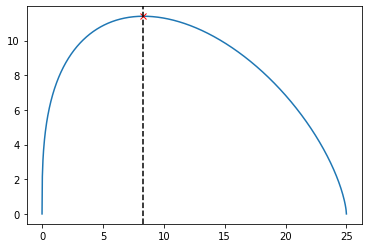

In [38]:
k_vec = np.linspace(0,25,1000)
f_vec = k_vec ** (1/3) * ((100-4*k_vec)/5) ** (2/3)
plt.plot(k_vec,f_vec)
plt.plot(8.33333045,11.399840,'rx')
plt.axvline(x=8.33333045, color="k", linestyle="--")
plt.show()

It's a quite nice optimization problem, but it seems a few methods fail.

#### Constrained multivariate methods

In [39]:
res_fminlbb = fmin_l_bfgs_b(obj1,10, fprime=True)
res_fminlbb

(array([8.3333414]),
 array([-11.39983964]),
 {'grad': array([7.10542677e-07]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 10,
  'nit': 4,
  'warnflag': 0})

In [40]:
res_fminc = fmin_cobyla(obj1,10,[lambda x: 25-x,lambda x: x])
res_fminc

array(8.33345195)

In [41]:
res_fminc = fmin_cobyla(obj2,x0,[lambda x: 100-4*x[0]-5*x[1],lambda x: x[0], lambda x: x[1]])
res_fminc

array([ 8.33322629, 13.33341897])

In [42]:
res_fmins = fmin_slsqp(obj2,x0,eqcons=[lambda x: 100-4*x[0]-5*x[1]], ieqcons=[lambda x: x[0], lambda x: x[1]])
res_fmins

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.39983964200147
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7


array([ 8.33358063, 13.33313549])

#### Univariate (scalar) minimization methods

In [43]:
res_fminb = fminbound(obj1,0,25)
res_fminb

8.333333301419751

In [44]:
res_brent = brent(obj1)
res_brent

8.333333239787706

In [45]:
res_golden = golden(obj1)
res_golden

8.333333174847871

#### (5) Plot

In [46]:
k_vec = np.linspace(3,16,100)
bgt = (100-4*k_vec)/5
l_vec1 = (10 ** 3 / k_vec) ** 0.5
l_vec2 = (11.39983964200147 ** 3 / k_vec) ** 0.5
l_vec3 = (12.5 ** 3 / k_vec) ** 0.5
l_vec4 = (13.5 ** 3 / k_vec) ** 0.5

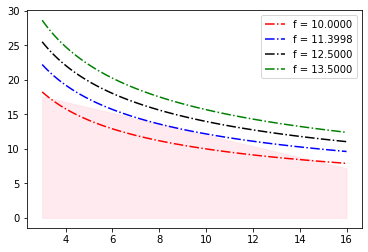

In [47]:
plt.fill_between(k_vec,bgt,color='pink',alpha=0.3)
plt.plot(k_vec,l_vec1,'r-.',k_vec,l_vec2,'b-.',k_vec,l_vec3,'k-.',k_vec,l_vec4,'g-.')
plt.legend(['f = 10.0000', 'f = 11.3998', 'f = 12.5000', 'f = 13.5000'])
plt.show()

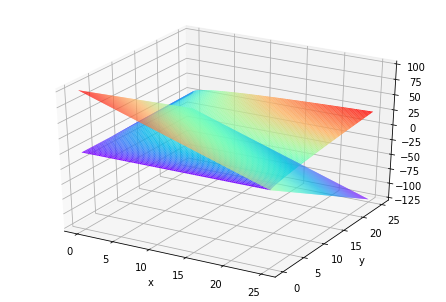

In [48]:
draw3D('X**(1/3) * Y**(2/3)','100-4*X-5*Y')

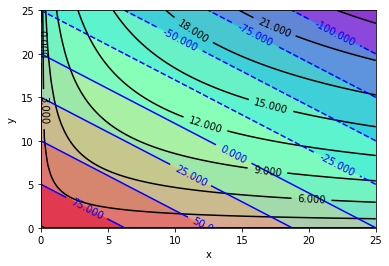

In [49]:
drawContour('X**(1/3) * Y**(2/3)','100-4*X-5*Y')

### Example 2: Aurtaky Economy (Nonlinear Objective with Nonlinear Constraint)

We assume an agent can produce according to his demands completely (namely that he has sufficient inputs). We impose constraints on his utility from the products and solve the minimal technology he needs to achieve. 

$$
\begin{aligned}
\min_{x,y} \quad & PPF = x^2 + y^2 \\
\text{s.t.} \quad & U = x^\frac{1}{3}y^\frac{2}{3} \geq 10
\end{aligned}
$$

### Analytical solution (Ex2)

We can solve out the Euler equation (obviously the constraint must bind, then we can reduce the KKT conditions):

$${\cal{L}} = x^2 + y^2 \underbrace{-}_{\text{Notice that this is minimization}} \lambda(x^\frac{1}{3}y^\frac{2}{3}-10)$$

$\implies$ F.O.C.s:

$$
\begin{aligned}
x:\quad & 2x - \frac{1}{3}x^{-\frac{2}{3}}y^{\frac{2}{3}}\lambda = 0 \\
y:\quad & 2y - \frac{2}{3}x^{\frac{1}{3}}y^{-\frac{1}{3}}\lambda = 0
\end{aligned}
$$

$\implies$

$$
\frac{x}{y} = \frac{1}{2}\frac{y}{x} \implies 2x^2 = y^2
$$

$\implies$ (Notice that x, y must be positive)

$$\begin{cases}x=\frac{10}{2^\frac{1}{3}} \\ y = 10\times2^\frac{1}{3} \end{cases}$$

In [50]:
x = 10 / 2 ** (1/3)
y = 10 * 2 ** (1/6)
print(x,y)

7.937005259840997 11.22462048309373


In [51]:
x,y = sp.symbols(['x','y'])
sp.solve([x/y - y/2/x, x**(1/3)*y**(2/3)-10],[x,y])

[(7.93700525984100, 11.2246204830937)]

### Numerical solution (Ex2)

In [52]:
def obj(x):
    return x[0] ** 2 + x[1] ** 2

In [53]:
x0 = [10,10]
bnds = [(0,None),]*2
cons_l = ({'type':'ineq','fun': lambda x: x[0] ** (1/3) * x[1] ** (2/3) - 10})
# cons_l = dict(type='ineq',fun = lambda x: x[0] ** (1/3) * x[1] ** (2/3) - 10})
cons_nl = lambda x: x[0] ** (1/3) * x[1] ** (2/3)
nlc = NonlinearConstraint(cons_nl, 10, np.Inf)

In [54]:
res_nl1 = try_minimize(obj, methods2, guess=x0, bounds=bnds, constraints=cons_l, min_flag=1, \
                       variate=1, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+--------------------+-------------------------+----------+--------------+
|    method    | success |      function      |         solution        |   time   | # iterations |
+--------------+---------+--------------------+-------------------------+----------+--------------+
|    SLSQP     |   True  | 188.98815748400176 | [   7.93701,   11.2246] | 0.001957 |      6       |
|    COBYLA    |   True  | 188.98815748423135 | [   7.93701,   11.2246] | 0.001025 |     None     |
| trust-constr |   True  | 188.98816388423265 | [   7.93701,   11.2246] | 0.029920 |      17      |
+--------------+---------+--------------------+-------------------------+----------+--------------+


In [55]:
res_nl2 = try_minimize(obj, methods2, guess=x0, bounds=bnds, constraints=nlc, min_flag=1, \
                       variate=1, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+--------------------+-------------------------+----------+--------------+
|    method    | success |      function      |         solution        |   time   | # iterations |
+--------------+---------+--------------------+-------------------------+----------+--------------+
|    SLSQP     |   True  | 188.98815748400176 | [   7.93701,   11.2246] | 0.004024 |      6       |
|    COBYLA    |   True  | 188.98815748423135 | [   7.93701,   11.2246] | 0.002996 |     None     |
| trust-constr |   True  | 188.98816388423265 | [   7.93701,   11.2246] | 0.026888 |      17      |
+--------------+---------+--------------------+-------------------------+----------+--------------+


### Plot (Ex 2)

In [56]:
x_vec = np.linspace(4,12,101)
y_vec_u = (10 ** 3 / x_vec) ** 0.5
y_vec1 = (160 - x_vec ** 2) ** 0.5
y_vec2 = (188 - x_vec ** 2) ** 0.5
y_vec3 = (208 - x_vec ** 2) ** 0.5

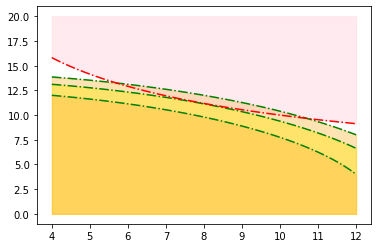

In [57]:
plt.fill_between(x_vec,y_vec1,color='pink',alpha=0.6)
plt.fill_between(x_vec,y_vec2,color='yellow',alpha=0.4)
plt.fill_between(x_vec,y_vec3,color='orange',alpha=0.3)
plt.plot(x_vec,y_vec1,'g-.',x_vec,y_vec2,'g-.',x_vec,y_vec3,'g-.')
plt.fill_between(x_vec,y_vec_u,20*np.ones(x_vec.shape),color='pink',alpha=0.3)
plt.plot(x_vec,y_vec_u,'r-.')
plt.show()

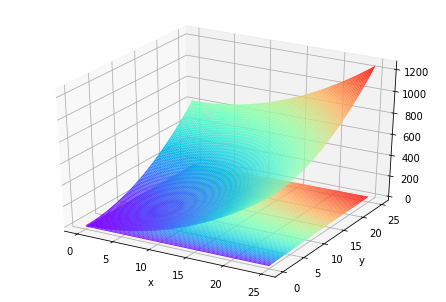

In [58]:
draw3D('X**2 + Y**2','X**(1/3)*Y**(2/3)-10')

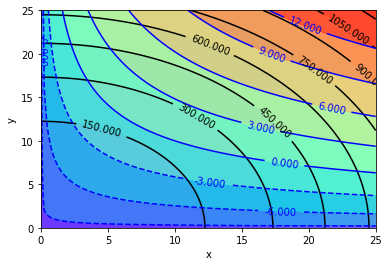

In [59]:
drawContour('X**2 + Y**2','X**(1/3)*Y**(2/3)-10')

### Example 3: Cubic Extension to Example 2

$$
\begin{aligned}
\min_{x,y} \quad & PPF = x^2 + y^2 + z^2 \\
\text{s.t.} \quad & U = x^\frac{1}{4}y^\frac{1}{2}z^\frac{1}{4} \geq 10
\end{aligned}
$$

### Analytical solution (Ex3)

$${\cal{L}} = x^2 + y^2 + z^2 - \lambda(x^\frac{1}{4}y^\frac{1}{2}z^\frac{1}{4}-10)$$

$\implies$ F.O.C.s

$$
\begin{aligned}
x:\quad & 2x - \frac{1}{4}x^{-\frac{3}{4}}y^\frac{1}{2}z^\frac{1}{4}\lambda = 0\\
y:\quad & 2y - \frac{1}{2}x^\frac{1}{4}y^{-\frac{1}{2}}z^\frac{1}{4}\lambda = 0\\
x:\quad & 2z - \frac{1}{4}x^\frac{1}{4}y^\frac{1}{2}z^{-\frac{3}{4}}\lambda = 0
\end{aligned}
$$

$\implies$

$$\begin{cases}\frac{x}{y} = \frac{1}{2}\frac{y}{x} \\ \frac{y}{z} = 2\frac{z}{y} \end{cases}$$

In [60]:
x,y,z = sp.symbols(['x','y','z'])
sp.solve([x**(1/4)*y**(1/2)*z**(1/4)-10,x/y-y/x/2,y/z-2*z/y])

[{x: 8.40896415253714, y: 11.8920711500272, z: 8.40896415253714}]

### Numerical solution (Ex3)

In [61]:
def obj3(x):
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2

In [62]:
x03 = [10,10,10]
bnds3 = [(0,None),]*3
cons_l = ({'type':'ineq','fun': lambda x: x[0] ** (1/4) * x[1] ** (1/2) * x[2] ** (1/4) - 10})
cons_nl = lambda x: x[0] ** (1/4) * x[1] ** (1/2) * x[2] ** (1/4)
nlc = NonlinearConstraint(cons_nl, 10, np.Inf)

In [63]:
res_nl1_3 = try_minimize(obj3, methods2, guess=x03, bounds=bnds3, constraints=cons_l, min_flag=1, \
                       variate=1, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+-------------------+------------------------------------+----------+--------------+
|    method    | success |      function     |              solution              |   time   | # iterations |
+--------------+---------+-------------------+------------------------------------+----------+--------------+
|    SLSQP     |   True  | 282.8427118648064 | [   8.40896,   11.8921,   8.40896] | 0.001994 |      5       |
|    COBYLA    |   True  | 282.8427124746174 | [   8.40896,   11.8921,   8.40896] | 0.000997 |     None     |
| trust-constr |   True  | 282.8427188746199 | [   8.40896,   11.8921,   8.40896] | 0.026928 |      17      |
+--------------+---------+-------------------+------------------------------------+----------+--------------+


In [64]:
res_nl2_3 = try_minimize(obj3, methods2, guess=x03, bounds=bnds3, constraints=nlc, min_flag=1, \
                       variate=1, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+-------------------+------------------------------------+----------+--------------+
|    method    | success |      function     |              solution              |   time   | # iterations |
+--------------+---------+-------------------+------------------------------------+----------+--------------+
|    SLSQP     |   True  | 282.8427118648064 | [   8.40896,   11.8921,   8.40896] | 0.001993 |      5       |
|    COBYLA    |   True  | 282.8427124746174 | [   8.40896,   11.8921,   8.40896] | 0.002992 |     None     |
| trust-constr |   True  | 282.8427188746199 | [   8.40896,   11.8921,   8.40896] | 0.027929 |      17      |
+--------------+---------+-------------------+------------------------------------+----------+--------------+


### Plot (Ex 3)

<IPython.core.display.Javascript object>


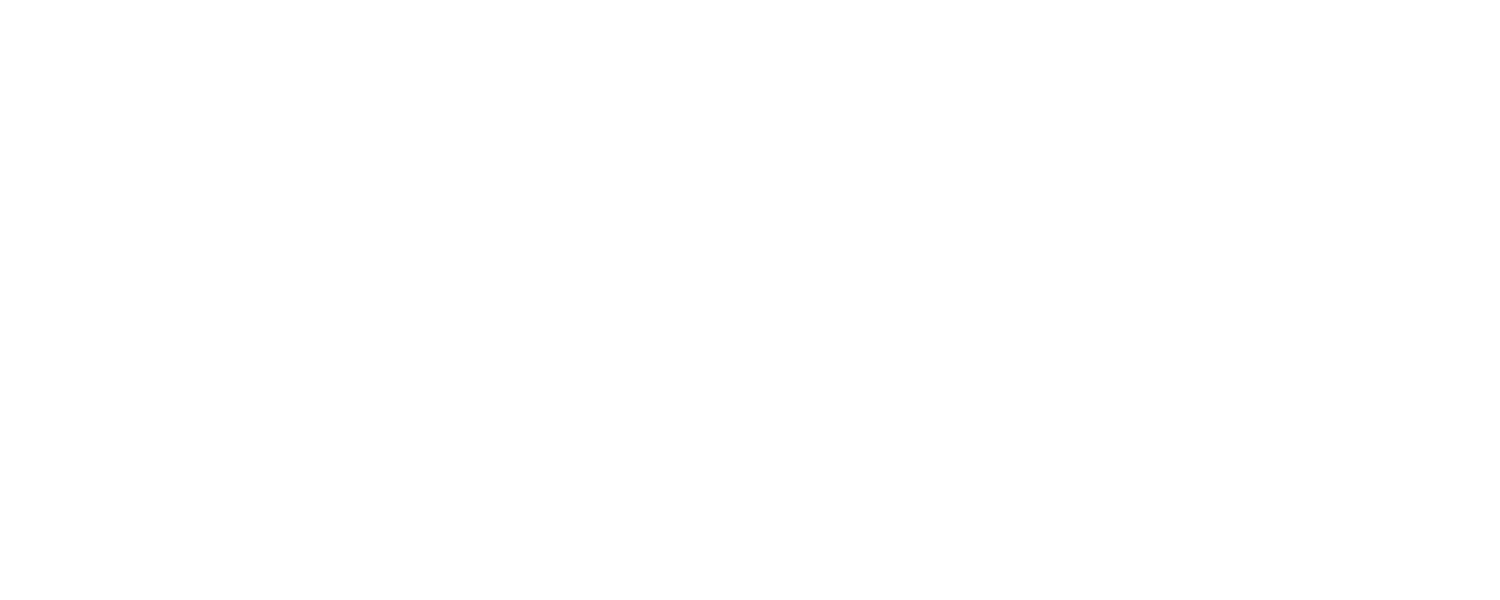

In [65]:
%matplotlib notebook
x_vec = np.linspace(1,13,101)
y_vec = np.linspace(1,13,101)
x,y = np.meshgrid(x_vec,y_vec)
# z_vec_u = (10 ** 4) / x_vec / (y_vec ** 2)  # only a curve
z_vec_u = (10 ** 4) / x / (y ** 2)

fig = plt.figure(1,[10,4])
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(x,y,z_vec_u,cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
ax1.set_zlabel('z')

z_vec_1 = (100 - x ** 2 - y ** 2) ** 0.5
z_vec_2 = (280 - x ** 2 - y ** 2) ** 0.5
z_vec_3 = (480 - x ** 2 - y ** 2) ** 0.5

ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(x,y,z_vec_1)
ax2.plot_surface(x,y,z_vec_2)
ax2.plot_surface(x,y,z_vec_3)
plt.xlabel('x')
plt.ylabel('y')
ax2.set_zlabel('z')

plt.show()

<IPython.core.display.Javascript object>


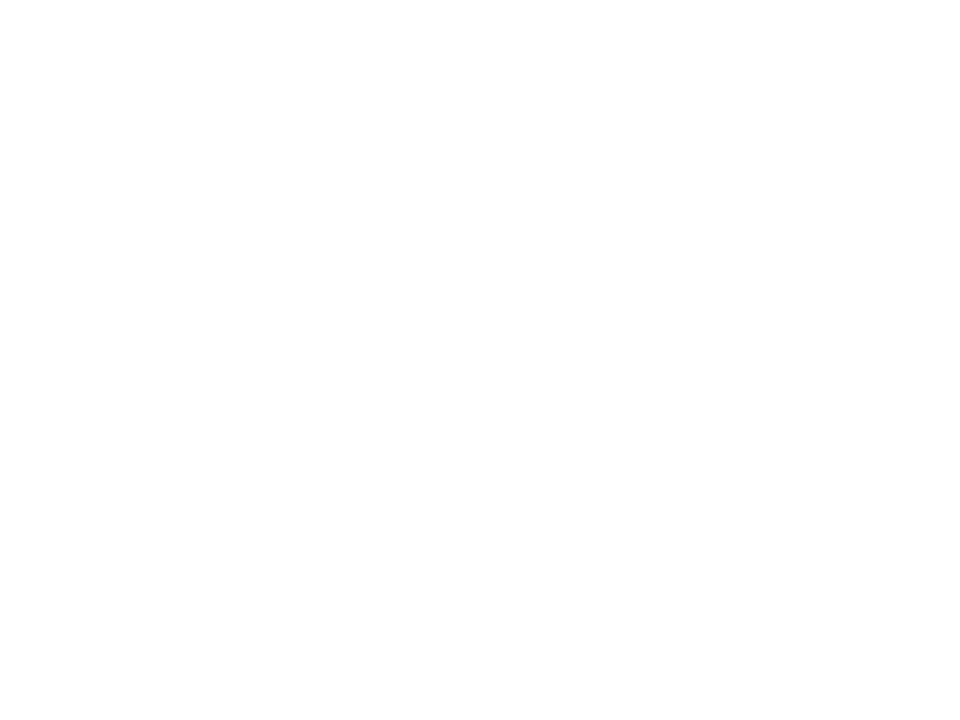

In [66]:
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z_vec_u,cmap='viridis',alpha=0.5)
ax.plot_surface(x,y,z_vec_1,cmap='rainbow',alpha=0.3)
ax.plot_surface(x,y,z_vec_2,alpha=0.1)
ax.plot_surface(x,y,z_vec_3,alpha=0.1)
ax.scatter(8.40896,11.8921,8.40896, 'b*', s=20)
plt.show()

### Example 4: Satiation Point

The above examples have binding constraints. We can also find some examples with unbinding constraints:

$$
\begin{aligned}
\max_{x,y}\quad & -(x-20)^2 - 2(y-1)^2 \\
\text{s.t.}: \quad & x + 2y \leq 50
\end{aligned}
$$

(obtained from quantecon data science lectures)

In [67]:
def f(x):
    return (x[0]-20)**2 + 2*(x[1]-1)**2
cons = dict(type='ineq',fun=lambda x: 50-x[0]-2*x[1])
bnds = [(0,None),]*2
x0 = [0,0]

In [68]:
filterwarnings("ignore")
res = try_minimize(f, methods2, guess=x0, bounds=bnds1, constraints=cons, \
                       variate=1, tol=1e-6)


---------------------------------------------------------------------------------

+--------------+---------+-------------------------+-------------------------+----------+--------------+
|    method    | success |         function        |         solution        |   time   | # iterations |
+--------------+---------+-------------------------+-------------------------+----------+--------------+
|    COBYLA    |   True  | -1.2978120368817914e-12 | [        20,  0.999999] | 0.000000 |     None     |
| trust-constr |   True  |  -2.760205150730927e-09 | [        20,   1.00004] | 0.024933 |      13      |
|    SLSQP     |   True  | -2.6319362068309176e-08 | [   19.9998,   0.99998] | 0.002993 |      4       |
+--------------+---------+-------------------------+-------------------------+----------+--------------+


In [69]:
filterwarnings("ignore")
res = try_minimize(f, methods2, guess=x0, bounds=bnds1, constraints=cons, \
                       command='basinhopping', variate=1)


---------------------------------------------------------------------------------

+--------------+---------+-------------------------+-------------------------+----------+--------------+
|    method    | success |         function        |         solution        |   time   | # iterations |
+--------------+---------+-------------------------+-------------------------+----------+--------------+
|    SLSQP     |   True  | -1.5276200862925988e-17 | [        20,         1] | 0.138592 |     100      |
|    COBYLA    |   True  |  -8.137723143841219e-14 | [        20,         1] | 0.041927 |     None     |
| trust-constr |   True  |  -1.10280642995018e-10  | [        20,   1.00001] | 1.574787 |     100      |
+--------------+---------+-------------------------+-------------------------+----------+--------------+


<IPython.core.display.Javascript object>


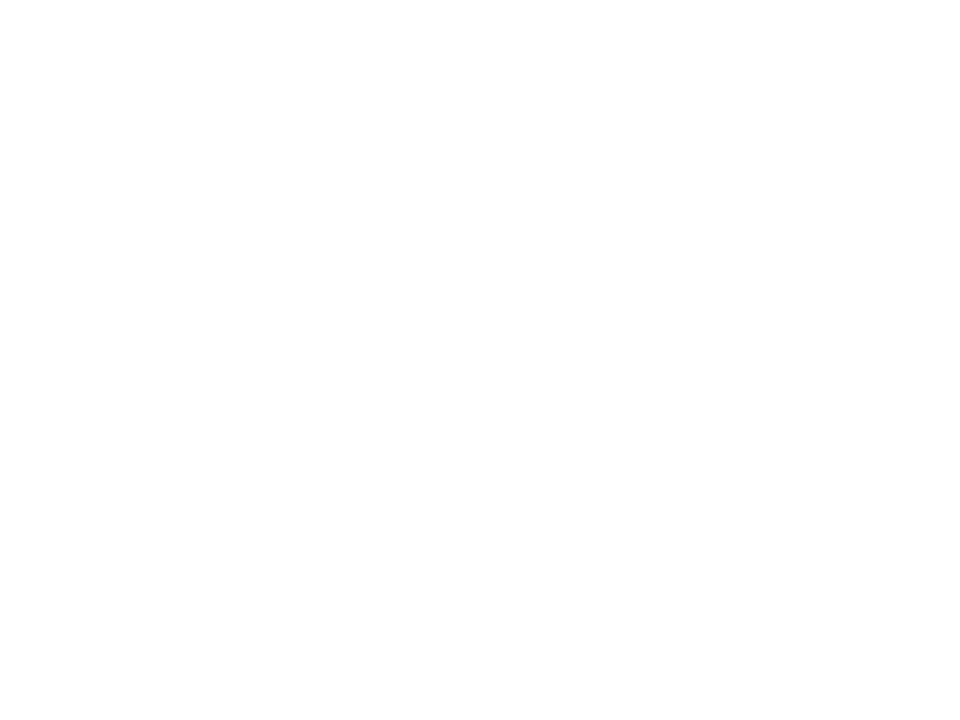

In [70]:
draw3D('-(X-20) ** 2 - 2 * (Y-1) ** 2', '50 - X - 2*Y')

In [71]:
drawContour('-(X-20) ** 2 - 2 * (Y-1) ** 2', '50 - X - 2*Y')

### Example 5: Linear Programming

We can also compare these methods with *linprog*. It's normal to expect that they cannot work as well as *linprog* in terms of dealing with linear programming problems, or even fail.

$$
\begin{aligned}
\max_{X,Y} \quad & Z = 2X + Y \\
\text{s.t.} \quad & 4X + Y \leq 400 \\
& X + Y \leq 300 \\
& 2X + 5Y \leq 200
\end{aligned}
$$

In [72]:
def obj5(x):
    return 2*x[0]+x[1]
bnds5 = [(0,None),]*2
cons = (dict(type='ineq',fun=lambda x: 400-4*x[0]-x[1]),
        dict(type='ineq',fun=lambda x: 300-x[0]-x[1]),
        dict(type='ineq',fun=lambda x: 200-2*x[0]-5*x[1]))

In [81]:
res5 = try_minimize(obj5,methods1,guess=[80,80],variate=1,bounds=bnds5,constraints=cons)

   Newton-CG: Jacobian is required for Newton-CG method
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+--------------+---------+------------------------+-----------------------------+----------+--------------+
|    method    | success |        function        |           solution          |   time   | # iterations |
+--------------+---------+------------------------+-----------------------------+----------+--------------+
| Nelder-Mead  |  False  | 1.7895839976094561e+46 |  [-9.7098e+45,1.52376e+45]  | 0.008558 |     200      |
|     BFGS     |  False  |   1055854281484.2163   | [-4.22342e+11,-2.11171e+11] | 0.031921 |      3       |
|      CG      |  False  |   20449

In [82]:
res5 = try_minimize(obj5,methods1,guess=[10,10],command='basinhopping', variate=1,bounds=bnds5,constraints=cons)

   Newton-CG: Jacobian is required for Newton-CG method
         TNC: `x0` violates bound constraints.
      dogleg: Jacobian is required for dogleg minimization
   trust-ncg: Jacobian is required for Newton-CG trust-region minimization
trust-krylov: ('Jacobian is required for trust region ', 'exact minimization.')
 trust-exact: Jacobian is required for trust region exact minimization.

---------------------------------------------------------------------------------

+--------------+---------+------------------------+-------------------------------+----------+--------------+
|    method    | success |        function        |            solution           |   time   | # iterations |
+--------------+---------+------------------------+-------------------------------+----------+--------------+
| Nelder-Mead  |  False  |          inf           | [-1.02225e+308,-4.25209e+303] | 0.541592 |     100      |
|     BFGS     |  False  | 4.235802475436551e+16  |   [-1.69432e+16,-8.4716e+15]  | 0.4